In [43]:
import torch
from torch import nn # contains PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(f"Using device: {device}")

2.1.1+cu121
Using device: cuda


# Preparing Data

In [44]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [45]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split].to(device), y[:train_split].to(device)
X_test, y_test = X[train_split:].to(device), y[train_split:].to(device)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# Predictions Graph

In [46]:
def plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(), test_data=X_test.cpu(), test_labels=y_test.cpu(), predictions=None, title=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    if title is not None:
        plt.title(title)
        
    plt.legend(prop={"size": 14})

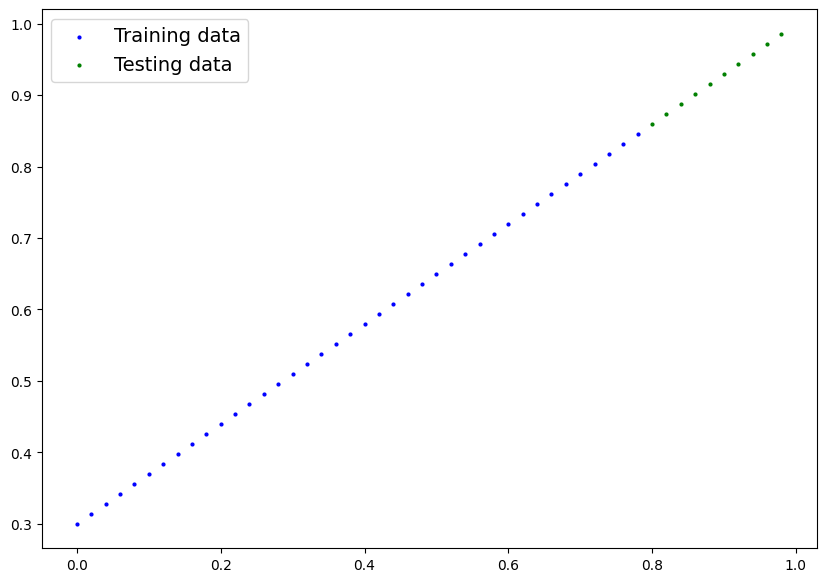

In [47]:
plot_predictions()

# Linear Regression Model
Used to build a standard linear regression model

In [48]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initializes random weight and bias parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [49]:
torch.manual_seed(1)
model_0 = LinearRegressionModel().to(device)
list(model_0.parameters()), model_0.state_dict()

([Parameter containing:
  tensor([[0.5153]], device='cuda:0', requires_grad=True),
  Parameter containing:
  tensor([-0.4414], device='cuda:0', requires_grad=True)],
 OrderedDict([('linear_layer.weight', tensor([[0.5153]], device='cuda:0')),
              ('linear_layer.bias', tensor([-0.4414], device='cuda:0'))]))

## Making Predictions

In [50]:
with torch.inference_mode():
    y_preds = model_0(X_test)

### Check the Predictions

In [51]:
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[-0.0292],
        [-0.0189],
        [-0.0086],
        [ 0.0017],
        [ 0.0121],
        [ 0.0224],
        [ 0.0327],
        [ 0.0430],
        [ 0.0533],
        [ 0.0636]], device='cuda:0')


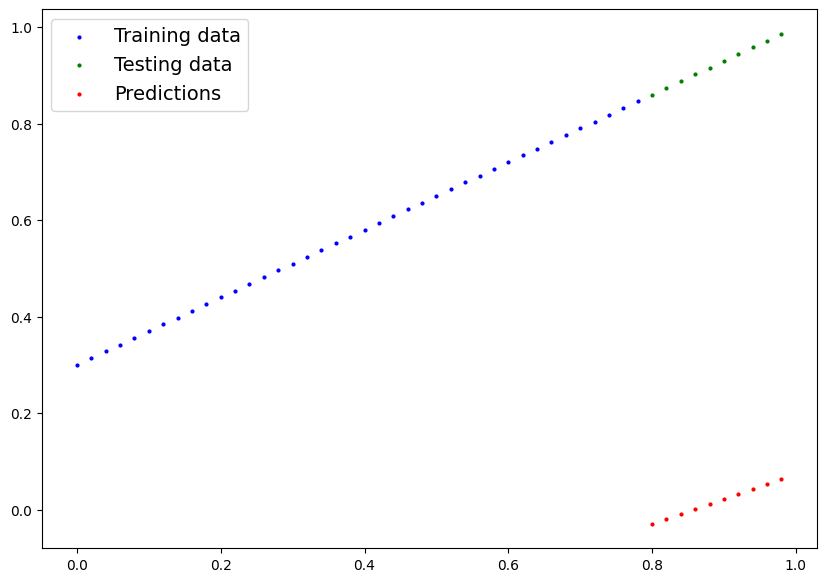

In [52]:
plot_predictions(predictions=y_preds.cpu())

# Loss function and Optimizer

In [53]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001) # lr is learning rate

# Testing and Training Loop

In [54]:
torch.manual_seed(42)

# number of times the model will pass over the training data
epochs = 2000

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Training
    
    # Model Training Mode
    model_0.train()
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate  loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    
    # 4. Backpropagation on the loss
    loss.backward()
    
    # 5. Update optimizer
    optimizer.step()
    
    # Testing
    
    # Model Evaluation Mode
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0(X_test)
        
        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        
        if epoch % 100 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.8134256601333618 | MAE Test Loss: 0.9044470191001892
Epoch: 100 | MAE Train Loss: 0.6982170939445496 | MAE Test Loss: 0.7697387933731079
Epoch: 200 | MAE Train Loss: 0.5830085873603821 | MAE Test Loss: 0.6350305676460266
Epoch: 300 | MAE Train Loss: 0.4677986204624176 | MAE Test Loss: 0.5003210306167603
Epoch: 400 | MAE Train Loss: 0.35258880257606506 | MAE Test Loss: 0.36561140418052673
Epoch: 500 | MAE Train Loss: 0.23737910389900208 | MAE Test Loss: 0.23090210556983948
Epoch: 600 | MAE Train Loss: 0.12216917425394058 | MAE Test Loss: 0.09619252383708954
Epoch: 700 | MAE Train Loss: 0.020254218950867653 | MAE Test Loss: 0.026844961568713188
Epoch: 800 | MAE Train Loss: 0.014354804530739784 | MAE Test Loss: 0.033468883484601974
Epoch: 900 | MAE Train Loss: 0.01091950386762619 | MAE Test Loss: 0.025469839572906494
Epoch: 1000 | MAE Train Loss: 0.007484687026590109 | MAE Test Loss: 0.017402147874236107
Epoch: 1100 | MAE Train Loss: 0.004050558898597956 | MAE

# Plot Loss Curves

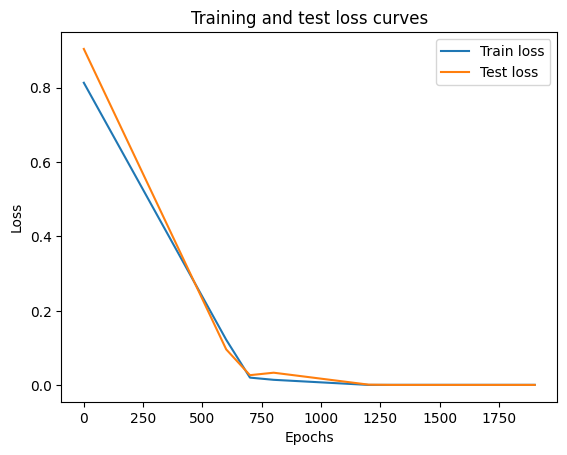

In [55]:
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [56]:
print("The model learned the following values for weight and bias:")
print(f"Weight: {model_0.state_dict()['weight'][0]} | Bias: {model_0.state_dict()['bias'][0]}")
print("Original values:")
print(f"Weight: {weight} | Bias: {bias}")

The model learned the following values for weight and bias:


KeyError: 'weight'

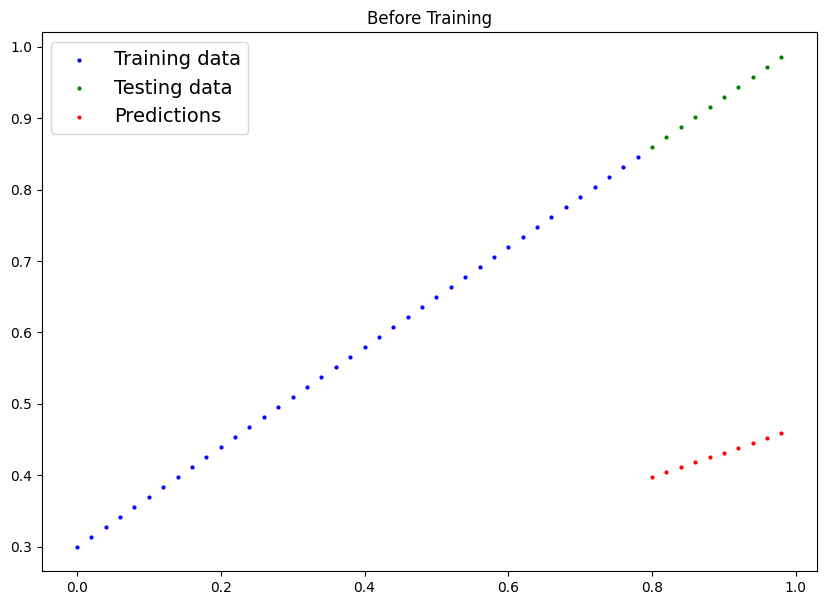

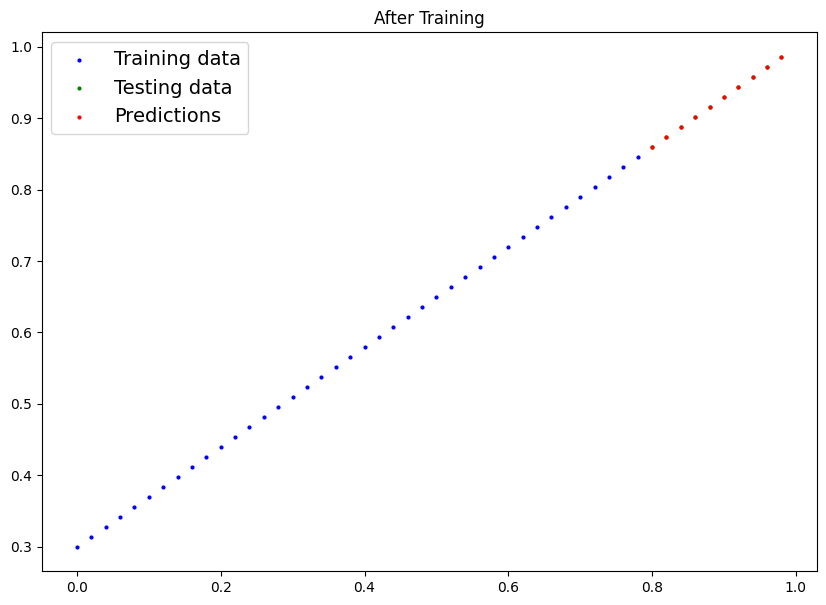

In [ ]:
plot_predictions(predictions=y_preds.cpu(), title="Before Training")
with torch.inference_mode():
    y_preds = model_0(X_test)
plot_predictions(predictions=y_preds.cpu(), title="After Training")

# Saving a PyTorch model's state_dict()

In [ ]:
# 1. Create models directoy
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "linear_regression_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models\linear_regression_model.pth


# Load model from state dict

In [ ]:
loaded_model_0 = LinearRegressionModel().to(device)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')